## Evocação do ritmo alpha

### 1. Importação das bibliotecas

In [167]:
%matplotlib inline

import matplotlib.pyplot as plt
import mne
import numpy as np
from copy import deepcopy
from mne.time_frequency import psd_welch as pw

### 2. Definição dos eletrodos e frequências

In [168]:
ch_names = ['po3', 'po4', 'p8', 'o1', 'o2', 'p7']
alpha = []
beta = []
theta = []
gamma = []
md_alpha = []
md_beta = []
md_theta = []
md_gamma = []
md_ritmos = []
global count
count = 0

### 3. Leitura do arquivo

A função a seguir (*load\_data*) faz o carregamento do arquivo com o conjunto de frequências _alpha_, _beta_, _gamma_, _delta_ e _theta_, obtidas a partir das leituras dos eletrodos definidos anteriormente.

In [169]:
def load_data(file):
    with open(file, 'r') as f:
        data = f.readlines()
    
    compactData = []
    for i in range(len(data)):
        if i >= 6:
            compactData.append(data[i])

    return compactData

### 4. Extração das informações relativas às frequências

A seguir são apresentadas duas funções: _convert_ e *separate\_data*. A primeira retorna um array com as informações relativas apenas aos dados de frequência de uma linha de arquivo passada como parâmetro, pois as linhas do arquivo eram compostas por ID's, tempo e leitura de eletrodos que não eram importantes nesse momento. Já a segunda função faz um mapeamento dos segundos que não possuíam leitura completa, isto é, o arquivo é composto por vários blocos de 256 itens, sendo que cada bloco desse corresponde à leitura de 1 segundo. Porém, alguns desses blocos tinham informações faltando, nao tinham os 256 itens. Dessa forma, a função *separate\_data* percorre o arquivo identificando quais são esses blocos defeituosos e, ao final, retorna um array com as informações relativas apenas às frequências (usa a função _convert_ para isso) dos segundos que possuem todas as informações.

In [170]:
def convert(data):
    temp = []
    line = data.split(',')

    for e in range(len(line)):
        if e > 0 and e <= 6:
            temp.append(float(line[e]))
    
    return temp

def separate_data(data):
    index = []
    temp = []
    count = 0

    for e in range(len(data)):
        idx = data[e].split(',')[0]
        if int(idx) == 255 and count == 255:
            index.extend(temp)
            temp = []
            count = 0
        elif int(idx) == 255 and count < 255:
            temp = []
            count = 0
        else:
            temp.append(convert(data[e]))
            count += 1
    
    return index

In [171]:
data = load_data('dataset_alpha/RAW_00.txt')
newData = separate_data(data)
size = int(len(newData)/256)

### 5. Plotando gráfico com os dados originais

A função *plot\_graph* constrói o gráfico com a leitura das frequências obtida dos dados. Até o momento, os dados estão em seu estado original, sem a aplicação de nenhum tipo de filtro.

In [172]:
def plot_graph(data):
    newData = np.asarray(data)
    newData = newData.T
    ch_types = ['eeg'] * 6

    info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types)
    raw = mne.io.RawArray(newData, info, verbose=False)
    
    montage = mne.channels.read_montage('standard_1020')
    raw.set_montage(montage)
    
    print("*******Dados originais*******\n")
    raw.plot_psd()
    return raw

*******Dados originais*******



<ipython-input-172-89cf24c02c2f>:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  raw.plot_psd()


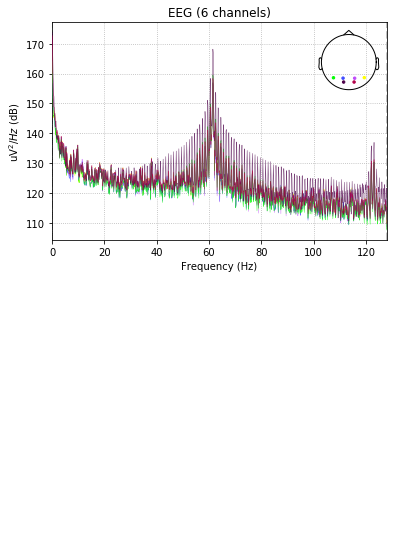

In [173]:
raw = plot_graph(newData)

### 6. Aplicando filtro notch

Com o intuito de reduzir o ruído nos dados, a função a seguir faz a aplicação do filtro notch.

In [174]:
def apply_notch(raw):
    newRaw = deepcopy(raw)
    newRaw.notch_filter(np.arange(60, 121, 60), fir_design='firwin')
    newRaw.filter(8., 50., fir_design='firwin')
    
    print("*******Dados com filtro notch*******\n")
    newRaw.plot_psd(area_mode='range', verbose=False)
    print()
    return newRaw

*******Dados com filtro notch*******



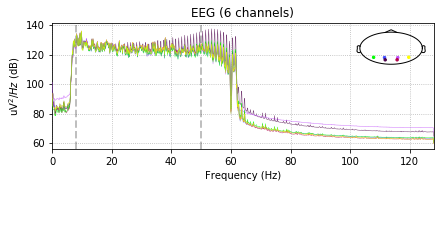

In [175]:
raw = apply_notch(raw)

### 7. Aplicando filtro bandpass

Para reduzir ainda mais os ruídos, a função a seguir aplica 10 vezes o filtro bandpass nos dados.

In [176]:
def apply_bandpass(raw):
    newRaw = deepcopy(raw)
    
    for i in range(0, 9):
        newRaw.filter(l_freq=8., h_freq=50.)
        
    return newRaw

### 8. Média quadrática

A função a seguir realiza a média quadrática de um array passado como parâmetro.

In [177]:
def avg(data):
    soma = 0
    for i in range(0, len(data)):
        soma = data[i] ** 2
    res = soma/len(data)
    res = res ** 1/2
    return res

### 9. Janelamento com psd_welch

Foi feita uma análise dos dados por meio da ferramenta openBCI e, com isso, verificou-se quais foram os intervalos de tempo em que o ritmo _alpha_ estava mais alto. A tabela a seguir apresenta esses intervalos. Vale ressaltar que o tempo total era de 830 segundos.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-uys7{border-color:inherit;text-align:center}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg" style="undefined;table-layout: fixed; width: 254px">
<colgroup>
<col style="width: 124px">
<col style="width: 130px">
</colgroup>
  <tr>
    <th class="tg-uys7"><span style="font-weight:bold">Início (s)</span></th>
    <th class="tg-uys7"><span style="font-weight:bold">Fim (s)</span></th>
  </tr>
  <tr>
    <td class="tg-uys7">11</td>
    <td class="tg-uys7">13</td>
  </tr>
  <tr>
    <td class="tg-uys7">77</td>
    <td class="tg-uys7">85</td>
  </tr>
  <tr>
    <td class="tg-c3ow">121</td>
    <td class="tg-c3ow">122</td>
  </tr>
  <tr>
    <td class="tg-c3ow">124</td>
    <td class="tg-c3ow">127</td>
  </tr>
  <tr>
    <td class="tg-baqh">198</td>
    <td class="tg-baqh">199</td>
  </tr>
  <tr>
    <td class="tg-baqh">244</td>
    <td class="tg-baqh">250</td>
  </tr>
  <tr>
    <td class="tg-baqh">252</td>
    <td class="tg-baqh">258</td>
  </tr>
  <tr>
    <td class="tg-baqh">300</td>
    <td class="tg-baqh">304</td>
  </tr>
  <tr>
    <td class="tg-baqh">314</td>
    <td class="tg-baqh">320</td>
  </tr>
  <tr>
    <td class="tg-baqh">410</td>
    <td class="tg-baqh">411</td>
  </tr>
  <tr>
    <td class="tg-0lax">607</td>
    <td class="tg-0lax">611</td>
  </tr>
</table>

A função a seguir constrói o gráfico para os intervalos passados como parâmetro e salva as intensidades dos eletrodos para cada um dos tipos de frequência.

### 10. Média para cada tipo de frequência e extração dos maiores valores de média

A função *avg\-freq* salva a média para cada ritmo, unificando os valores obtidos das diferentes frequências de um ritmo em um único valor para cada eletrodo.

A função *large\-md* retorna o índice do eletrodo da maior média dentre todas as frequências.

In [178]:
def avg_freq():
    del md_alpha[0:-1]
    del md_beta[0:-1]
    del md_theta[0:-1]
    del md_gamma[0:-1]
    
    for i in range(0, 6):
        md_theta.append(avg(theta[i]))
        md_alpha.append(avg(alpha[i]))
        md_beta.append(avg(beta[i]))
        md_gamma.append(avg(gamma[i]))
        
def large_md(data):
    maior = -1
    pos = 0
    pos_aux = pos
    for i in range(0, len(data)):
        for element in data[i]:
            if element > maior:
                maior = element
                pos = pos_aux
            pos_aux += 1
        pos_aux = 0
    return pos-1

def plot_time_frequency(raw, i, f):
    del alpha[0:-1]
    del beta[0:-1]
    del theta[0:-1]
    del gamma[0:-1]
    
    newRaw = apply_bandpass(raw)
    
    psds, freqs = pw(newRaw, 5., 50., i, f)
    print("*******Dados após psd_welch*******\n")      
    for j in range(0, 6):
        theta.append(psds[j][0:3])
        alpha.append(psds[j][3:8])
        beta.append(psds[j][8:25])
        gamma.append(psds[j][20:46])
    avg_freq()

### 12. Comparação das médias e mapeamento para uma escala
A função a seguir realiza a comparação dos valores dos ritmos. Quando tem-se em *alpha* o maior valor medido em um eletrodo, imprime-se um comparativo dos ritmos e seus valores(em Hz) colhidos nesse eletrodo.

Por fim, nas ultimas linhas, é feito um mapeamento da diferença entre o valor da média de *alpha* e o segundo maior valor de média para uma escala que varia de 0 à 100. 

In [179]:
def extract_large():
    del md_ritmos[0:-1]
    md_ritmos.append(md_alpha)
    md_ritmos.append(md_beta)
    md_ritmos.append(md_gamma)
    md_ritmos.append(md_theta)
    
    idx = large_md(md_ritmos)
    maior = max(md_alpha[idx], md_beta[idx], md_theta[idx], md_gamma[idx])
    global count
    if md_alpha[idx] == maior:
        count += 1
        print("***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***")
        print("Eletrodo: ", ch_names[idx])
        print("Alpha (8-12)Hz: ", md_alpha[idx])
        print("Beta (12-30)Hz: ", md_beta[idx])
        print("Gamma (25-50)Hz: ", md_gamma[idx])
        print("Theta (4-7)Hz: ", md_theta[idx])
        print("*************\n")
        values = [md_alpha[idx], md_beta[idx], md_gamma[idx], md_theta[idx]]
        names = ['alpha', 'beta', 'gamma', 'theta']
        plt.bar(names, values, color=['pink', 'blue', 'purple', 'gray'])
        plt.show()
        print("*************\n")
        print("***Mapeando para escala de 0 à 100: ***")
        segundo_maior = max(md_beta[idx], md_theta[idx], md_gamma[idx])
        diferenca = md_alpha[idx] - segundo_maior
        escala = (100*diferenca)/md_alpha[idx]
        print("Média de alpha: ", md_alpha[idx])
        print("Segunda maior média: ", segundo_maior)
        print("Valor na escala: ", escala)

### 13. Bufferização da entrada de dados
Os laços a seguir são responsáveis por realizar a bufferização dos dados, que são analisados sempre de 4 em 4 segundos, com deslocamento progressivo de 1 segundo. A partir desses intervalos de dados as ações 7-12 acima são executadas.

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  p7
Alpha (8-12)Hz:  0.23319924956611637
Beta (12-30)Hz:  0.0022599866022396746
Gamma (25-50)Hz:  0.00903255484543586
Theta (4-7)Hz:  0.03177040918669643
*************



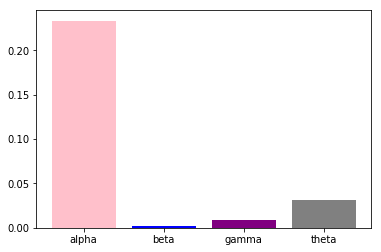

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  0.23319924956611637
Segunda maior média:  0.03177040918669643
Valor na escala:  86.37628155073075
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o2
Alpha (8-12)Hz:  0.24266732995661594
Beta (12-30)Hz:  0.07096433449685922
Gamma (25-50)Hz:  0.048236366089120374
Theta (4-7)Hz:  0.17364970230729218
*************



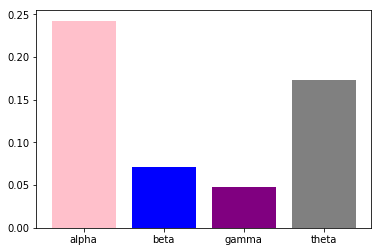

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  0.24266732995661594
Segunda maior média:  0.17364970230729218
Valor na escala:  28.441252335723448
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o2
Alpha (8-12)Hz:  2.0324962773383946
Beta (12-30)Hz:  0.06957144477659397
Gamma (25-50)Hz:  0.03861842058355057
Theta (4-7)Hz:  0.1726938721715989
*************



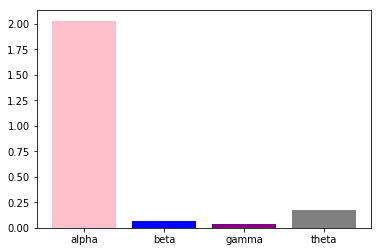

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  2.0324962773383946
Segunda maior média:  0.1726938721715989
Valor na escala:  91.50336096075188
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o2
Alpha (8-12)Hz:  1.7112710271836324
Beta (12-30)Hz:  0.04160612211692914
Gamma (25-50)Hz:  0.1919117637690422
Theta (4-7)Hz:  0.10909969741864035
*************



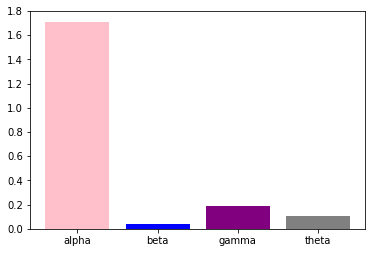

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  1.7112710271836324
Segunda maior média:  0.1919117637690422
Valor na escala:  88.7854255275457
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o1
Alpha (8-12)Hz:  0.0834212375287964
Beta (12-30)Hz:  0.012549341852311527
Gamma (25-50)Hz:  0.020763333386984016
Theta (4-7)Hz:  0.012129630764042706
*************



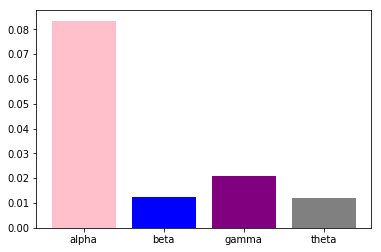

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  0.0834212375287964
Segunda maior média:  0.020763333386984016
Valor na escala:  75.11025489184732
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o1
Alpha (8-12)Hz:  0.03295366814840699
Beta (12-30)Hz:  0.01235131960677581
Gamma (25-50)Hz:  0.024343017185376736
Theta (4-7)Hz:  0.03161585010649157
*************



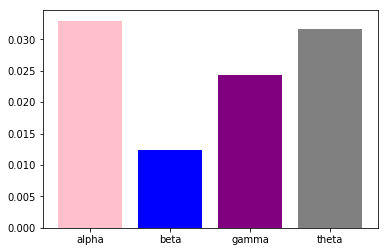

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  0.03295366814840699
Segunda maior média:  0.03161585010649157
Valor na escala:  4.059693858330259
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o1
Alpha (8-12)Hz:  0.3829224586085943
Beta (12-30)Hz:  0.008592210315804035
Gamma (25-50)Hz:  0.03211077328854581
Theta (4-7)Hz:  0.031699806348158756
*************



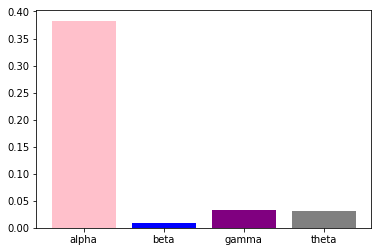

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  0.3829224586085943
Segunda maior média:  0.03211077328854581
Valor na escala:  91.6142883326235
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o1
Alpha (8-12)Hz:  0.4503139953087098
Beta (12-30)Hz:  0.003352594212726856
Gamma (25-50)Hz:  0.01743417959189472
Theta (4-7)Hz:  0.043236058754117984
*************



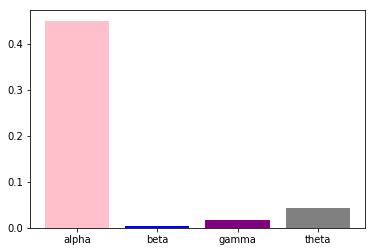

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  0.4503139953087098
Segunda maior média:  0.043236058754117984
Valor na escala:  90.39868642668371
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o1
Alpha (8-12)Hz:  0.3724029479126845
Beta (12-30)Hz:  0.017312382684331218
Gamma (25-50)Hz:  0.011897410605952955
Theta (4-7)Hz:  0.043569403083280896
*************



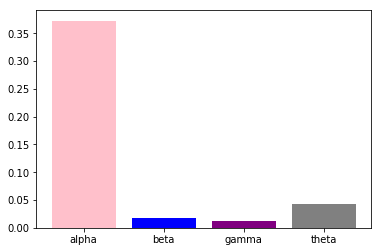

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  0.3724029479126845
Segunda maior média:  0.043569403083280896
Valor na escala:  88.30046772521887
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  p7
Alpha (8-12)Hz:  1.377735934463223
Beta (12-30)Hz:  0.07301529990959624
Gamma (25-50)Hz:  0.075734747219364
Theta (4-7)Hz:  0.004640376021629326
*************



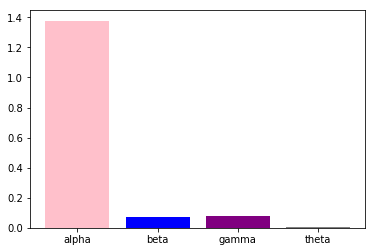

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  1.377735934463223
Segunda maior média:  0.075734747219364
Valor na escala:  94.50295623966063
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o2
Alpha (8-12)Hz:  1.8682611278514483
Beta (12-30)Hz:  0.10680105352855548
Gamma (25-50)Hz:  0.025879123891265468
Theta (4-7)Hz:  0.1691543973607171
*************



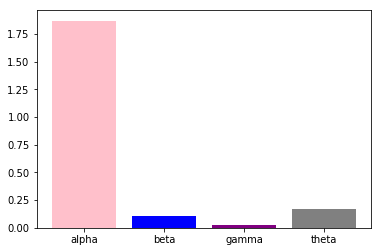

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  1.8682611278514483
Segunda maior média:  0.1691543973607171
Valor na escala:  90.94589108347776
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o2
Alpha (8-12)Hz:  1.6681192141699612
Beta (12-30)Hz:  0.09833496523412968
Gamma (25-50)Hz:  0.026200368184963466
Theta (4-7)Hz:  0.1497870446365778
*************



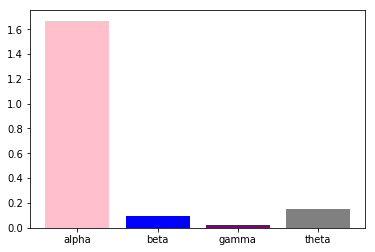

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  1.6681192141699612
Segunda maior média:  0.1497870446365778
Valor na escala:  91.02060312211496
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o2
Alpha (8-12)Hz:  0.9632889730269586
Beta (12-30)Hz:  0.041227348442769346
Gamma (25-50)Hz:  0.026661976147933027
Theta (4-7)Hz:  0.17136626303544988
*************



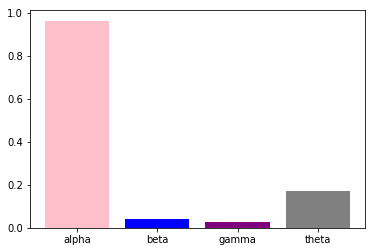

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  0.9632889730269586
Segunda maior média:  0.17136626303544988
Valor na escala:  82.2102953699384
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o2
Alpha (8-12)Hz:  1.1275897740948904
Beta (12-30)Hz:  0.04779769998103828
Gamma (25-50)Hz:  0.07721019271053851
Theta (4-7)Hz:  0.21108663833515115
*************



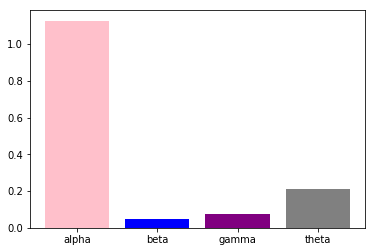

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  1.1275897740948904
Segunda maior média:  0.21108663833515115
Valor na escala:  81.27983747417458
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  po3
Alpha (8-12)Hz:  2.0890103733018806
Beta (12-30)Hz:  0.017695272414139387
Gamma (25-50)Hz:  0.25676983712643775
Theta (4-7)Hz:  0.0332609619690395
*************



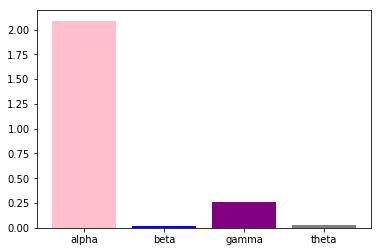

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  2.0890103733018806
Segunda maior média:  0.25676983712643775
Valor na escala:  87.70854178571702
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o2
Alpha (8-12)Hz:  1.3631099686727743
Beta (12-30)Hz:  0.10487713839639368
Gamma (25-50)Hz:  0.03643434611705877
Theta (4-7)Hz:  0.30370308297735027
*************



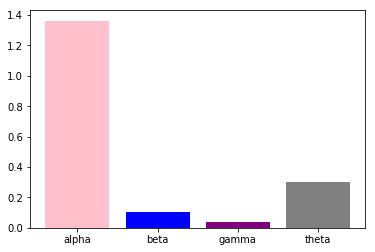

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  1.3631099686727743
Segunda maior média:  0.30370308297735027
Valor na escala:  77.71983992802443
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o2
Alpha (8-12)Hz:  1.478171329407444
Beta (12-30)Hz:  0.12917577701297842
Gamma (25-50)Hz:  0.05077671809333765
Theta (4-7)Hz:  0.2201860874902867
*************



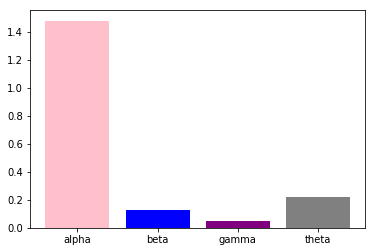

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  1.478171329407444
Segunda maior média:  0.2201860874902867
Valor na escala:  85.10415652706828
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  po3
Alpha (8-12)Hz:  1.9508621056361455
Beta (12-30)Hz:  0.11994950377926082
Gamma (25-50)Hz:  0.03311650769679418
Theta (4-7)Hz:  0.06695247881218634
*************



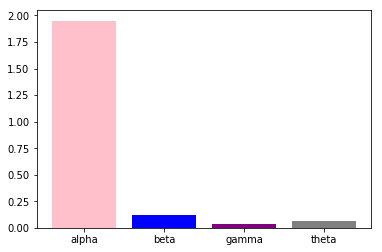

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  1.9508621056361455
Segunda maior média:  0.11994950377926082
Valor na escala:  93.85146169825533
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o2
Alpha (8-12)Hz:  0.7700019456971405
Beta (12-30)Hz:  0.2521889376771301
Gamma (25-50)Hz:  0.022759800843575876
Theta (4-7)Hz:  0.0861705292673911
*************



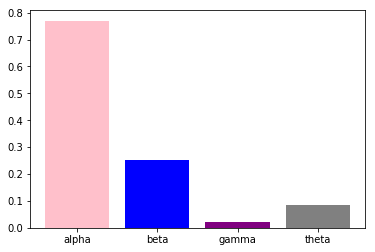

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  0.7700019456971405
Segunda maior média:  0.2521889376771301
Valor na escala:  67.24827267172624
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o1
Alpha (8-12)Hz:  0.16034382645579692
Beta (12-30)Hz:  0.06955165153237286
Gamma (25-50)Hz:  0.03509598138539682
Theta (4-7)Hz:  0.01744045965945452
*************



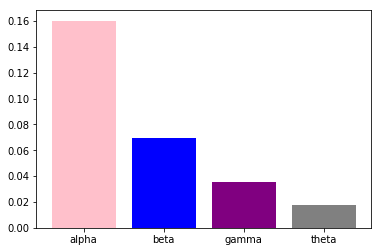

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  0.16034382645579692
Segunda maior média:  0.06955165153237286
Valor na escala:  56.62343036852334
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o2
Alpha (8-12)Hz:  8.924891148171081
Beta (12-30)Hz:  0.22905508063525978
Gamma (25-50)Hz:  0.22126190538330123
Theta (4-7)Hz:  0.07513294420570656
*************



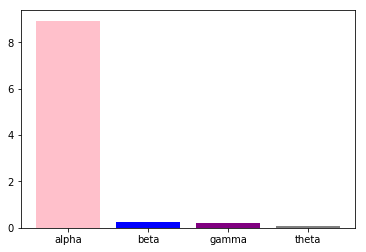

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  8.924891148171081
Segunda maior média:  0.22905508063525978
Valor na escala:  97.43352521803924
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o2
Alpha (8-12)Hz:  10.39914328572173
Beta (12-30)Hz:  0.18003980234323813
Gamma (25-50)Hz:  0.025249250568177804
Theta (4-7)Hz:  0.05441447146458337
*************



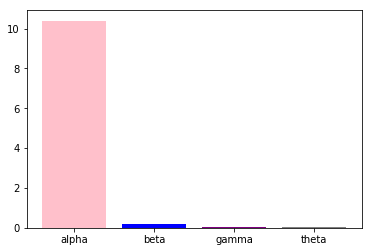

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  10.39914328572173
Segunda maior média:  0.18003980234323813
Valor na escala:  98.26870543662538
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  o2
Alpha (8-12)Hz:  10.661794915335957
Beta (12-30)Hz:  0.15683630133168405
Gamma (25-50)Hz:  0.014970204152623299
Theta (4-7)Hz:  0.055142991360108105
*************



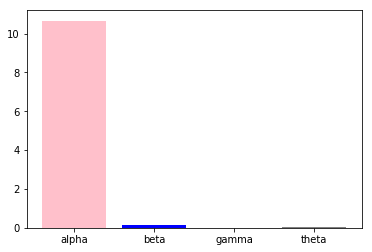

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  10.661794915335957
Segunda maior média:  0.15683630133168405
Valor na escala:  98.52898782449765
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  p7
Alpha (8-12)Hz:  2.8731204937897274
Beta (12-30)Hz:  0.006616289899175004
Gamma (25-50)Hz:  0.06143948510010249
Theta (4-7)Hz:  0.002114589107867319
*************



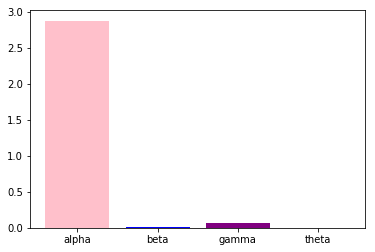

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  2.8731204937897274
Segunda maior média:  0.06143948510010249
Valor na escala:  97.86157645553313
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  p7
Alpha (8-12)Hz:  1.0898351007438278
Beta (12-30)Hz:  0.013664137167219093
Gamma (25-50)Hz:  0.3602191828634954
Theta (4-7)Hz:  0.007649333083970492
*************



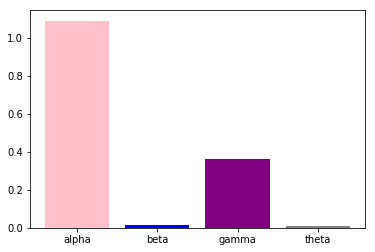

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  1.0898351007438278
Segunda maior média:  0.3602191828634954
Valor na escala:  66.9473682195003
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  p7
Alpha (8-12)Hz:  0.5994963285244485
Beta (12-30)Hz:  0.34795081447859255
Gamma (25-50)Hz:  0.20959207265612517
Theta (4-7)Hz:  0.0679430018835115
*************



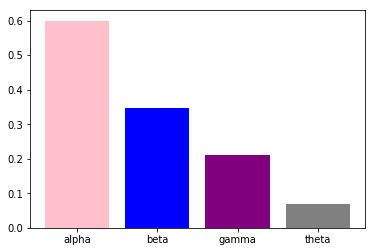

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  0.5994963285244485
Segunda maior média:  0.34795081447859255
Valor na escala:  41.95947532572711
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  p7
Alpha (8-12)Hz:  0.34227972250956407
Beta (12-30)Hz:  0.013199582329902714
Gamma (25-50)Hz:  0.025485070575677907
Theta (4-7)Hz:  0.009198248584270674
*************



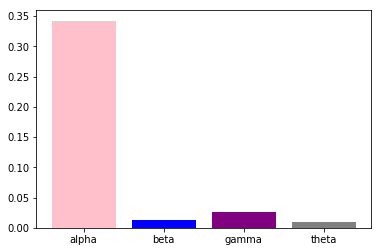

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  0.34227972250956407
Segunda maior média:  0.025485070575677907
Valor na escala:  92.55431481922923
size:  795
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

***Comparação do maior valor em eletrodo considerando todos o ritmo Alpha:***
Eletrodo:  p7
Alpha (8-12)Hz:  1.8360253997020184
Beta (12-30)Hz:  0.020920224742668116
Gamma (25-50)Hz:  0.02106518860986161
Theta (4-7)Hz:  0.053382806340186856
*************



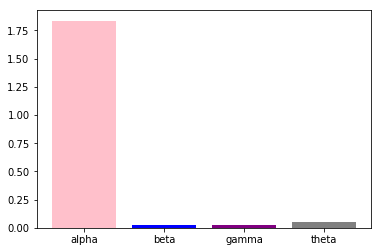

*************

***Mapeando para escala de 0 à 100: ***
Média de alpha:  1.8360253997020184
Segunda maior média:  0.053382806340186856
Valor na escala:  97.09247996520905
Qtd de vezes que alpha é maior:  28


In [180]:
for i in range(1, 4):
    plot_time_frequency(raw, 0, i)
    extract_large()

for i in range(0, size):#size
    plot_time_frequency(raw, i, i+4)
    extract_large()

print("Qtd de vezes que alpha é maior: ", count)